# Text2vec-base-multilingual

https://huggingface.co/shibing624/text2vec-base-multilingual

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ktrain


import matplotlib.pyplot as plt
import pandas as pd

threshold = [4,5, 6, 8, 9, 10]
file_list_1 = ["data_3005(puntoevirgola).csv","data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
file_list_2 = ["data_0905_semicolon.csv","data_2705_semicolon.csv","data_3005(puntoevirgola).csv","data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
target = [-1, 0, 1]
col = ["Ticker"] + ["Article " + str(i + 1) for i in range(10)] + ["Target"] + ["Concatenated Titles"]

c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


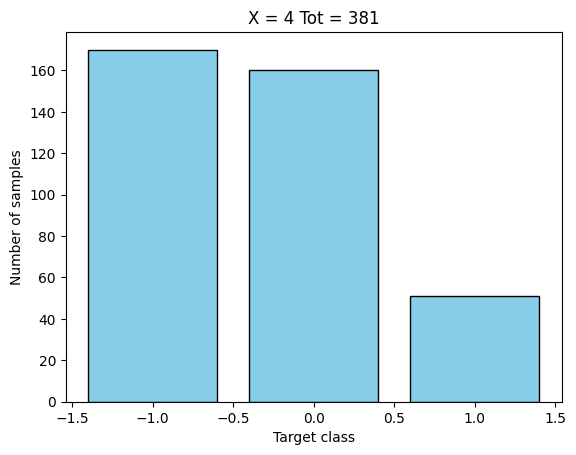

[170, 160, 51]


,Ticker,Article 1,Article 2,Article 3,Article 4,Article 5,Article 6,Article 7,Article 8,Article 9,Article 10,Target,Concatenated Titles
135,HAL,"Top news on May 28: HAL stock in focus, Rafale...","Should you buy Bharti Airtel, Hindustan Aerona...",Halliburton (NYSE:HAL) Shares Sold by D.A. Dav...,"HAL stock in focus as India, France to begin t...",,,,,,,1.0,"Top news on May 28: HAL stock in focus, Rafale..."
216,WST,US Bancorp DE Sells 93 Shares of West Pharmace...,West to Participate in Upcoming Investor Confe...,"UBS Group AG Acquires 11,245 Shares of West Ph...",UBS Group AG Grows Stock Holdings in West Phar...,,,,,,,-1.0,US Bancorp DE Sells 93 Shares of West Pharmace...
48,LULU,What's Going On With Lululemon Stock? - Lulule...,Lululemon Athletica (LULU) Reported Lackluster...,Can lululemon (LULU) Q1 Earnings Beat on Stron...,July 12th Options Now Available For lululemon ...,,,,,,,1.0,What's Going On With Lululemon Stock? - Lulule...


In [3]:
all_data_set = pd.DataFrame(columns=col)  # Initialize DataFrame for each threshold
T = 4
for file_name in file_list_1:                                                                           #METTERE FILE LIST 1
    data_set = pd.read_csv(file_name, sep=";")
    input_df = pd.DataFrame(columns=col)
    for ticker in data_set["Ticker"].unique():
        ticker_df = data_set[data_set["Ticker"] == ticker]
        articles_list = ticker_df["Titles"].to_list()
        if len(articles_list) >= T:
            articles_list = articles_list[:T]
            ticker_target = ticker_df["Target"].iloc[0]
            new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
            input_df.loc[len(input_df.index)] = new_row
    all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)
# Cleaning the columns
for i in range(1, 11):
    column_name = f'Article {i}'
    all_data_set[column_name] = all_data_set[column_name].str.replace('<title>', '').str.replace('</title>', '')
all_data_set["Concatenated Titles"] = all_data_set["Concatenated Titles"].str.replace('<title>', '').str.replace('</title>', '')

input_df = all_data_set

'''
# We rebalance the dataset
num_rows_to_keep = max(all_data_set[all_data_set["Target"] == 1].shape[0], all_data_set[all_data_set["Target"] == -1].shape[0])

subset_to_keep = all_data_set[all_data_set["Target"] == 0].sample(n = num_rows_to_keep)
input_df = pd.concat([subset_to_keep,all_data_set[all_data_set["Target"] == 1],all_data_set[all_data_set["Target"] == -1]])
'''

plt.bar( target ,[input_df[input_df["Target"] == t ].shape[0] for t in target], color='skyblue', edgecolor='black')

plt.xlabel('Target class')
plt.ylabel('Number of samples')
plt.title('X = '+ str(T)+" Tot = " +str(input_df.shape[0]))

plt.show()
print([input_df[input_df["Target"] == t ].shape[0] for t in target])
input_df = input_df.dropna(axis=0)
input_df.sample(n=3)

In [4]:
from sklearn.model_selection import train_test_split

X = input_df.filter(["Concatenated Titles"],axis=1)
Y = input_df.filter(["Target"],axis=1)
#print(Y)

x_train, x_Final_test, y_train, y_Final_test = train_test_split( X, Y, test_size=0.20, random_state=42)
x_train, x_test, y_train, y_test = train_test_split( x_train, y_train, test_size=0.20, random_state=42)

y_train = y_train + 1            
y_test = y_test + 1
y_Final_test = y_Final_test + 1

### Here starts the model training

In [5]:
from sentence_transformers import SentenceTransformer

model_name = 'shibing624/text2vec-base-multilingual'
m = SentenceTransformer(model_name)  

In [6]:
c = len(m.encode("I love embeddings!"))                   # dim embedding
r = x_train.shape[0]    # dim dataset  

x_train_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_train.iloc[idx,:].loc["Concatenated Titles"])
  x_train_emb[idx,:] = sentence_embeddings



r = x_test.shape[0]    # dim dataset  
x_val_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_test.iloc[idx,:].loc["Concatenated Titles"])
  x_val_emb[idx,:] = sentence_embeddings


r = x_Final_test.shape[0]    # dim dataset  
x_test_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_Final_test.iloc[idx,:].loc["Concatenated Titles"])
  x_test_emb[idx,:] = sentence_embeddings

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [8]:
#to train the NN we need to convert integer output to binary array
num_classes = 3

y_train_dummy = np.zeros((len(y_train), num_classes))
for i in range(0,len(y_train)):
    class_idx = round(y_train.Target.iloc[i])  
    y_train_dummy[i, class_idx] = 1


y_val_dummy = np.zeros((len(y_test), num_classes))
for i in range(0,len(y_test)):
  y_val_dummy[i,round(y_test.Target.iloc[i])] = 1

y_test_dummy = np.zeros((len(y_Final_test), num_classes))
for i in range(0,len(y_Final_test)):
  y_test_dummy[i,round(y_Final_test.Target.iloc[i])] = 1

In [9]:
def create_m1(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=100, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',                                    # tf.keras.losses.CategoricalCrossentropy should be more appropriate but I cannot make it work
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0) 
    return model
def create_m2(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)  
    return model

def create_m3(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=300, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)  
    return model
def create_m4(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=900, activation='relu', input_dim=c))
    model.add(Dense(units=50, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0) 
    return model

def get_validation_missclas(y_pred, target):
    pred_test_2 = np.zeros(y_pred.shape)
    for i in range(len(y_pred)):
        pred_test_2[i, y_pred[i,:].argmax()  ] = 1

    miss_test = np.sum(  abs(pred_test_2-target)/2)   /y_pred.shape[0]
    return miss_test

def get_validation_missclas(y_pred, target):
    return np.sum(y_pred != target) / len(target)


In [ ]:
fun_lst = [create_m1,create_m2,create_m3,create_m4]
epo_list = [3, 5,10,20,100]
lr = 0.001                              # values between 0.001 and 0.0001 shoul be fine 
batch_size_list = [5,8,10,20] 
best_performance = 10
# 80 models will be trained
for function in fun_lst:
    for epo in epo_list:
        for bat in batch_size_list:
            model = function(epo,lr,bat,x_train_emb,y_train_dummy)
            pred_train_raw=model.predict(x_train_emb)
            pred_train = np.argmax(pred_train_raw, axis=1)
            miss = get_validation_missclas(pred_train,y_train["Target"].to_numpy())
            if miss < best_performance:
                best_performance = miss
                opt_model, opt_fun, opt_epo, opt_bat = model, function, epo, bat

In [12]:
print(best_performance, opt_model, opt_fun, opt_epo, opt_bat,sep="\n")
predictions = opt_model.predict(x_test_emb)

0.29218106995884774
<function create_m4 at 0x000002AC632E51F8>
20
8
3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 2ms/step
Precision (train): 0.87620727303267
Recall (train): 0.7078189300411523
F1-score (train): 0.7111810825084822
Precision (val): 0.43368470056196584
Recall (val): 0.26229508196721313
F1-score (val): 0.31792189256963044
Precision (test): 0.442987012987013
Recall (test): 0.38961038961038963
F1-score (test): 0.3971437297305158
MSE_train: 0.5027008053190456
MSE_val: 0.47061330530732665
MSE_test: 0.45485788971562346
MSE_train (binary): 0.19478737997256515
MSE_val (binary): 0.4918032786885246
MSE_test (binary): 0.4069264069264069
Misclassification_train: 0.09739368998628258
Misclassification_val: 0.2459016393442623
Misclassification_test: 0.20346320346320346


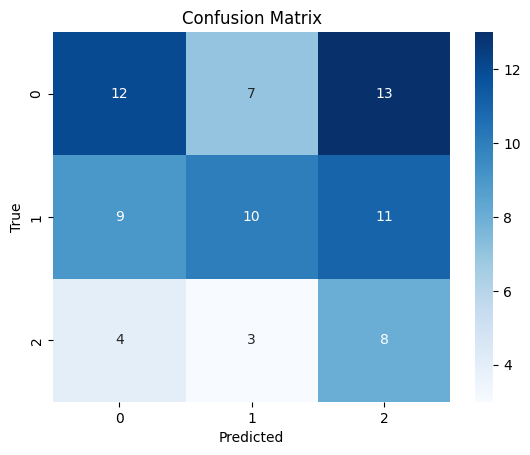

In [13]:
model  = opt_model
# Install whichever package or library is missing for you
#!pip install sentence-transformers
#!pip install numpy pandas scikit-learn seaborn matplotlib keras
#import pandas as pd
#import numpy as np
#import tensorflow as tf
import seaborn as sns
#import matplotlib.pyplot as plt
#import random as rand
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam, RMSprop, SGD, Adagrad
#from sentence_transformers import SentenceTransformer
#from transformers import TFBertForSequenceClassification, BertTokenizer, BertConfig
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Making predictions
pred_train = model.predict(x_train_emb)
pred_val = model.predict(x_val_emb)
pred_test = model.predict(x_test_emb)

# Converting predictions to binary arrays
def to_binary(pred):
    pred_binary = np.zeros(pred.shape)
    for i in range(len(pred)):
        pred_binary[i, pred[i, :].argmax()] = 1
    return pred_binary

pred_train_2 = to_binary(pred_train)
pred_val_2 = to_binary(pred_val)
pred_test_2 = to_binary(pred_test)

# Converting predictions to class labels
y_train_pred_labels = np.argmax(pred_train, axis=1)
y_val_pred_labels = np.argmax(pred_val, axis=1)
y_test_pred_labels = np.argmax(pred_test, axis=1)

# Converting one-hot encoded true labels to class labels
y_train_true_labels = np.argmax(y_train_dummy, axis=1)
y_val_true_labels = np.argmax(y_val_dummy, axis=1)
y_test_true_labels = np.argmax(y_test_dummy, axis=1)

# Evaluating the model (precision, recall, F1-score, MSE, misclassification and confusion matrix)

# Presicison, recall and F1-Score
def evaluate_performance(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

precision_train, recall_train, f1_train = evaluate_performance(y_train_true_labels, y_train_pred_labels)
precision_val, recall_val, f1_val = evaluate_performance(y_val_true_labels, y_val_pred_labels)
precision_test, recall_test, f1_test = evaluate_performance(y_test_true_labels, y_test_pred_labels)

print("Precision (train):", precision_train)
print("Recall (train):", recall_train)
print("F1-score (train):", f1_train)

print("Precision (val):", precision_val)
print("Recall (val):", recall_val)
print("F1-score (val):", f1_val)

print("Precision (test):", precision_test)
print("Recall (test):", recall_test)
print("F1-score (test):", f1_test)

# Mean Squared Error and misclassification rate
def mean_squared_error(y_true, y_pred):
    return np.mean((y_pred - y_true) ** 2)

MSE_train = mean_squared_error(y_train_dummy, pred_train)
MSE_val = mean_squared_error(y_val_dummy, pred_val)
MSE_test = mean_squared_error(y_test_dummy, pred_test)

print("MSE_train:", MSE_train)
print("MSE_val:", MSE_val)
print("MSE_test:", MSE_test)

MSE_train_2 = mean_squared_error(y_train_dummy, pred_train_2)
MSE_val_2 = mean_squared_error(y_val_dummy, pred_val_2)
MSE_test_2 = mean_squared_error(y_test_dummy, pred_test_2)

print("MSE_train (binary):", MSE_train_2)
print("MSE_val (binary):", MSE_val_2)
print("MSE_test (binary):", MSE_test_2)

def misclassification_rate(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / 2)

miss_train = misclassification_rate(y_train_dummy, pred_train_2)
miss_val = misclassification_rate(y_val_dummy, pred_val_2)
miss_test = misclassification_rate(y_test_dummy, pred_test_2)

print("Misclassification_train:", miss_train)
print("Misclassification_val:", miss_val)
print("Misclassification_test:", miss_test)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_true_labels, y_test_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()